In [1]:
import torchvision.models as models
import torch.optim as optim
import torch
import torch.nn as nn
from Train import trainmodel
from efficientnet_pytorch import EfficientNet
from imageloader import *
from sklearn.metrics import confusion_matrix

In [2]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, savename, title='Confusion Matrix'):
    classes =['cardboard','glass', 'metal','paper','plastic','trash']
    plt.figure(figsize=(12, 8), dpi=100)
    np.set_printoptions(precision=2)

    # 在混淆矩阵中每格的概率值
    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=15, va='center', ha='center')
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')
    
    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    
    # show confusion matrix
    plt.savefig(savename, format='png')
    plt.show()

In [3]:
test_folder = "./garbage_dataset/test_set"
batch_size = 6
device = 9
model_name_list = ["EfficientNet","alexnet","vgg16_bn","vgg19_bn","mobilenet_v2",\
                   "densenet161","densenet121","resnet18","resnet34",\
                   "resnet50""resnet101"]
'''efficient_net = EfficientNet.from_pretrained('efficientnet-b7',num_classes=6)
alexnet = models.alexnet(pretrained=False)
alexnet.classifier=nn.Sequential(nn.Linear(9216,4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(4096,256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256,6))
vgg16_bn = models.vgg16_bn(pretrained=False)
vgg16_bn.classifier=nn.Sequential(nn.Linear(25088,4096),nn.ReLU(inplace = True),\
                               nn.Dropout(0.5),nn.Linear(4096,4096),\
                               nn.ReLU(inplace = True),nn.Dropout(0.5),nn.Linear(4096,6))
vgg19_bn = models.vgg19_bn(pretrained = False)
vgg19_bn.classifier=nn.Sequential(nn.Linear(25088,4096),nn.ReLU(inplace = True),\
                               nn.Dropout(0.5),nn.Linear(4096,4096),\
                               nn.ReLU(inplace = True),nn.Dropout(0.5),nn.Linear(4096,6))

mobilenet_v2 = models.mobilenet_v2(pretrained=False)
mobilenet_v2.classifier = nn.Sequential(nn.Dropout(0.2),nn.Linear(1280,6))
densenet161 = models.densenet161(pretrained = False)
densenet161.classifier=nn.Linear(2208,6)'''
'''densenet121 = models.densenet121(pretrained = False)
densenet121.classifier=nn.Linear(1024,6)
resnet18 = models.resnet18(pretrained = False)
resnet18.fc=nn.Linear(512,6)
resnet34 = models.resnet34(pretrained = False)
resnet34.fc=nn.Linear(512,6)'''

resnet101 = models.resnet101(pretrained = False)
resnet101.fc=nn.Linear(2048,6)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
0.8723897911832946
[0.97911833 0.95359629 0.96983759 0.95359629 0.92343387 0.96519722]
[0.91428571 0.84146341 0.91176471 0.90740741 0.87837838 0.62068966]
[0.95522388 0.90789474 0.89855072 0.90740741 0.73033708 0.81818182]
[0.93430657 0.87341772 0.90510949 0.90740741 0.79754601 0.70588235]


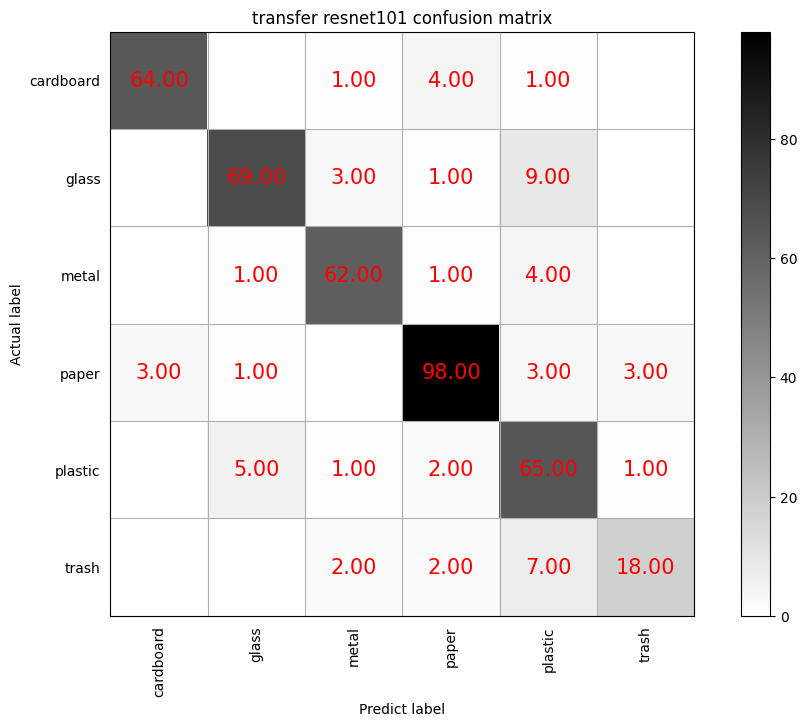

In [4]:
dict = torch.load("./param/transfer_resnet101_ADAM99",map_location="cuda:8")
model = resnet101
model.load_state_dict(dict)
model.eval()
model.to("cuda:9")
lossfunc = torch.nn.CrossEntropyLoss().cuda(device)
testset,size3=image_data_loader(test_folder,batch_size)
y_pred=[]
y_true=[]
test_loss = 0.0
for i, data in enumerate(testset):
    (inputs, labels) = data
    inputs = inputs.cuda(device)
    labels = labels.cuda(device)
    outputs = model(inputs)
    loss = lossfunc(outputs, labels)
    test_loss += loss.item() * inputs.size(0)
    ret, predictions = torch.max(outputs.data, 1)
    predictions=predictions.cpu()
    labels = labels.cpu()
    y_pred.extend(list(np.array(predictions)))
    y_true.extend(list(np.array(labels)))
cm = confusion_matrix(y_true,y_pred)
crcount = 0
for i in range(len(y_pred)):
    if (y_pred[i]==y_true[i]):
        crcount+=1
print(crcount/len(y_pred))
        
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
precision = TP / (TP+FP)  # 查准率
recall = TP / (TP+FN)  # 查全率
accuracy=(TP+TN)/(TP+TN+FP+FN)
f1=(2*precision*recall)/(precision+recall)
print(accuracy)
print(recall)
print(precision)
print(f1)
plot_confusion_matrix(cm, './cm/res101.png', title='transfer resnet101 confusion matrix')

